<a href="https://colab.research.google.com/github/asadali163/Time-Series-Experiments/blob/main/codebase/ARIMA(with_stock_prices).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O sp500.csv https://lazyprogrammer.me/course_files/sp500sub.csv

--2024-07-11 09:30:59--  https://lazyprogrammer.me/course_files/sp500sub.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473876 (24M) [text/csv]
Saving to: ‘sp500.csv’

sp500.csv           100%[===================>]  24.29M  36.9MB/s    in 0.7s    

2024-07-11 09:31:00 (36.9 MB/s) - ‘sp500.csv’ saved [25473876/25473876]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
df = pd.read_csv('sp500.csv', index_col="Date", parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.3 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm

In [ ]:
goog = df[df['Name'] == 'GOOG'][['Close']]
goog.head()

,Close
Date,
2010-01-04,312.204773
2010-01-05,310.829926
2010-01-06,302.994293
2010-01-07,295.940735
2010-01-08,299.885956


In [ ]:
goog.shape

(2263, 1)

In [ ]:
goog.isnull().sum()

Close    0
dtype: int64

<Axes: xlabel='Date'>

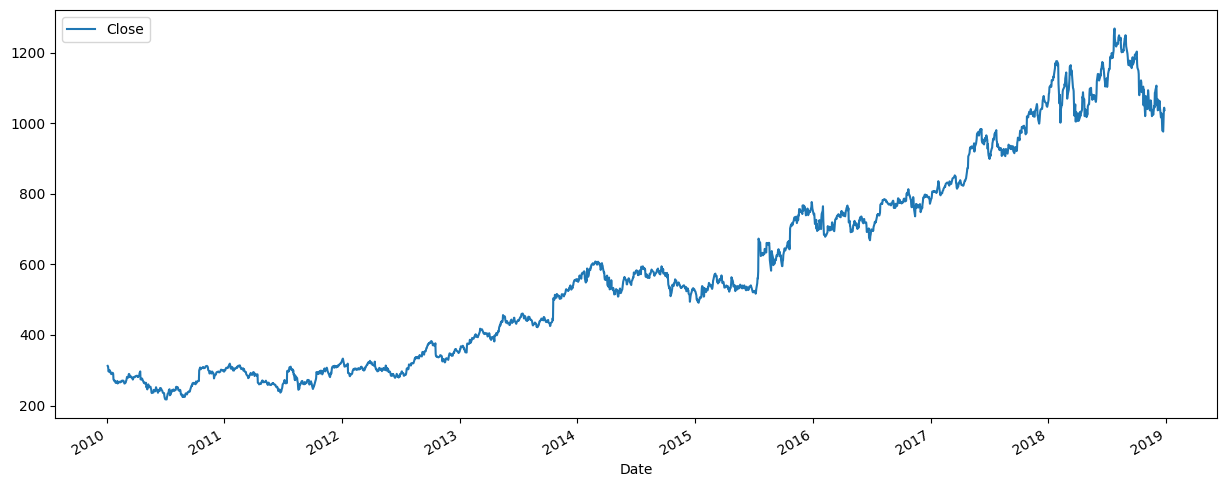

In [ ]:
goog.plot(figsize=(15,6))

In [ ]:
N_train = 50
train = goog.iloc[:-N_train]
test = goog.iloc[-N_train:]

In [ ]:
test.head()

,Close
Date,
2010-03-17,281.724030
2010-03-18,282.142456
2010-03-19,278.954407
2010-03-22,277.709076
2010-03-23,273.474945


Now let's check for some difference value

In [ ]:
def adfuller_test(series):
  result = adfuller(series)
  print("Test Hypothesis: ", result[0])
  print("p-value: ", result[1])
  if (result[1] <= 0.05):
    print("Staionary")
  else:
    print("Non-Stationary")


In [ ]:
adfuller_test(goog['Close'])

Test Hypothesis:  -0.09329881527671637
p-value:  0.9501019204142657
Non-Stationary


In [ ]:
goog['LogClose'] = np.log(goog['Close'])
goog.drop(columns=['LogClose'], axis=1, inplace=True)
goog.head()

,Close
Date,
2010-01-04,312.204773
2010-01-05,310.829926
2010-01-06,302.994293
2010-01-07,295.940735
2010-01-08,299.885956


<Axes: xlabel='Date'>

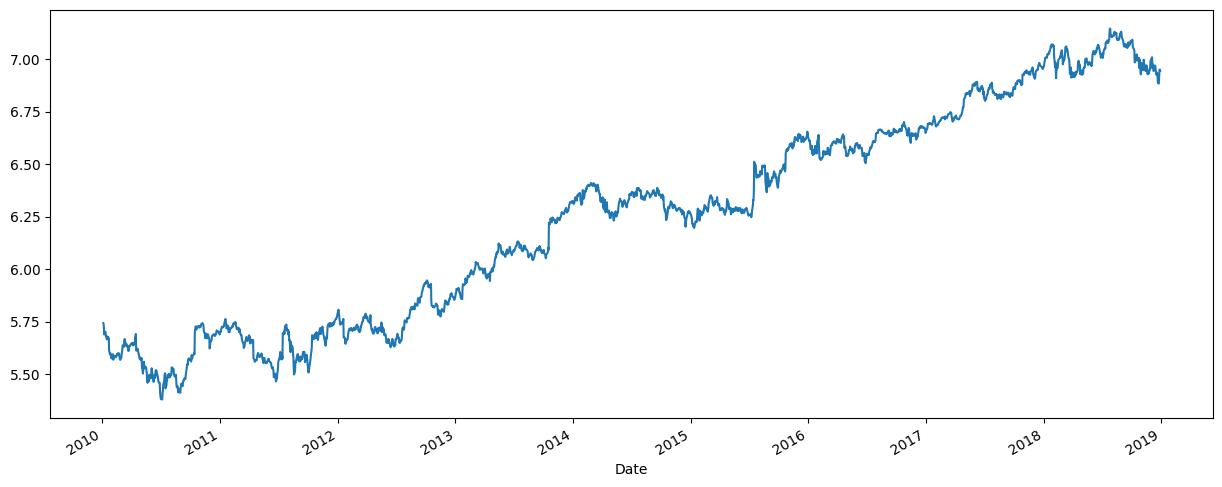

In [ ]:
goog['LogClose'].plot(figsize=(15,6))

In [ ]:
adfuller_test(goog['LogClose'])

Test Hypothesis:  -0.41819025789061465
p-value:  0.9070170677498406
Non-Stationary


In [ ]:
goog['1stDifference'] = goog['Close'].diff()
goog['Log1stDifference'] = np.log(goog['1stDifference'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Date'>

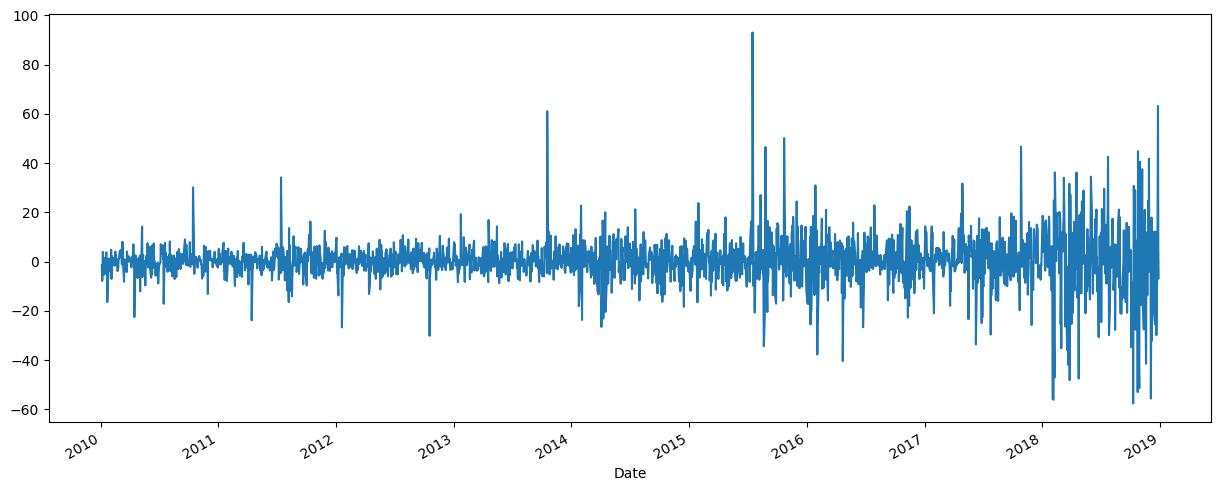

In [ ]:
goog['1stDifference'].plot(figsize=(15,6))

In [ ]:
adfuller_test(goog['1stDifference'][1:])

Test Hypothesis:  -8.837168614178418
p-value:  1.7067429223209098e-14
Staionary


In [ ]:
# Remove the log 1st difference column
goog.drop('Log1stDifference', axis=1, inplace=True)
goog.head()

,Close,LogClose,1stDifference
Date,,,
2010-01-04,312.204773,5.743659,NaN
2010-01-05,310.829926,5.739246,-1.374847
2010-01-06,302.994293,5.713714,-7.835632
2010-01-07,295.940735,5.690159,-7.053558
2010-01-08,299.885956,5.703402,3.945221


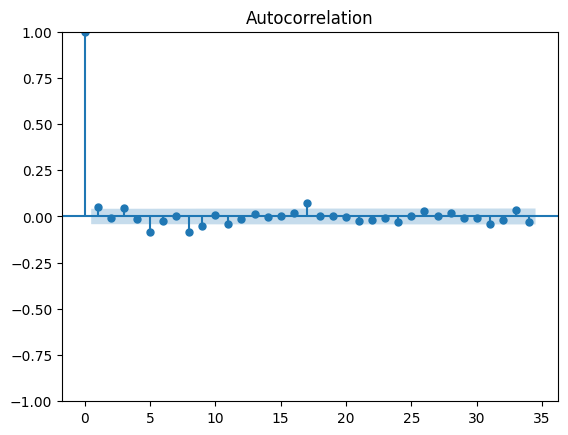

In [ ]:
fig, ax = plt.subplots()
plot_acf(train['Close'].diff()[1:], ax=ax);

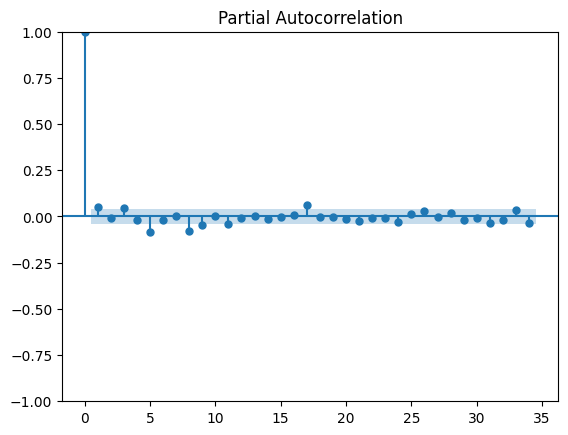

In [ ]:
fig, ax = plt.subplots()
plot_pacf(train['Close'].diff()[1:], ax=ax);

As we can see that the 1st difference is stationary, so most likely, we will use the Integrated (I) value = 1

##### Now let's check for ACF and PACF Plots as well

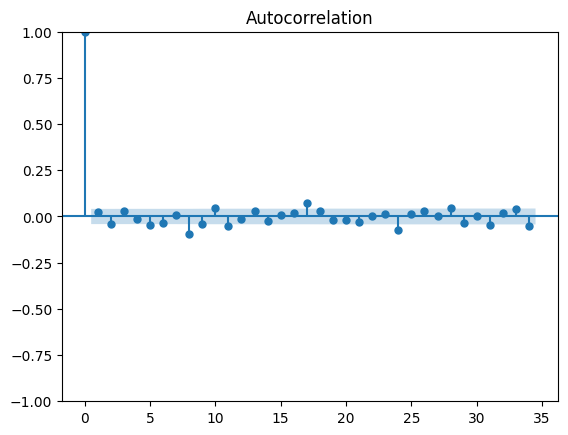

In [ ]:
fig, ax = plt.subplots()
plot_acf(goog['1stDifference'][1:], ax=ax);

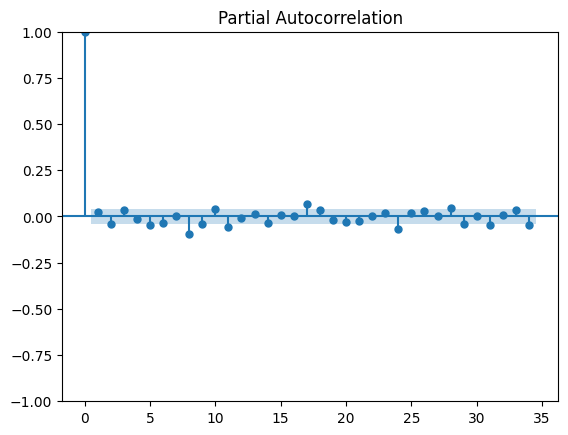

In [ ]:
fig, ax = plt.subplots()
plot_pacf(goog['1stDifference'][1:], ax=ax);

So in my understanding with 1st difference, we should select the p, and q value to be 8, 8

##### Let's try now the auto arima model to check what it selects for seasonal and without seasonal

In [ ]:
model = pm.auto_arima(train, suppress_warnings=True, trace=True, error_action='ignore', seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15974.311, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15973.446, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15970.138, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15970.034, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15975.144, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15970.726, Time=1.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15971.772, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15972.704, Time=2.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15971.403, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 7.415 seconds


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2213
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -7982.017
Date:                Thu, 11 Jul 2024   AIC                          15970.034
Time:                        11:32:56   BIC                          15987.139
Sample:                             0   HQIC                         15976.282
                               - 2213                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3664      0.200      1.834      0.067      -0.025       0.758
ma.L1          0.0502      0.012      4.031      0.000       0.026       0.075
sigma2        79.7692      0.934     85.362      0.000      77.938      81.601
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13145.21
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.20   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred, confint = model.predict(n_periods=len(test), return_conf_int=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
def plot_result(model, fulldata, train, test):
  params = model.get_params()
  d = params['order'][1]
  train_pred = model.predict_in_sample(start=d, end=-1)
  pred, confint = model.predict(n_periods=N_train, return_conf_int=True)

  fig, ax = plt.subplots(figsize=(15,6))
  ax.plot(fulldata.index, fulldata, label='data')
  ax.plot(train.index[d:], train_pred,  label='fitted')
  ax.plot(test.index, pred, label='prediction')
  ax.fill_between(test.index, confint[:,0], confint[:,1], color='b', alpha=0.3)
  ax.legend()
  plt.show();

In [ ]:
print(goog.shape)
print(train.shape)
print(test.shape)

(2263, 1)
(2213, 1)
(50, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


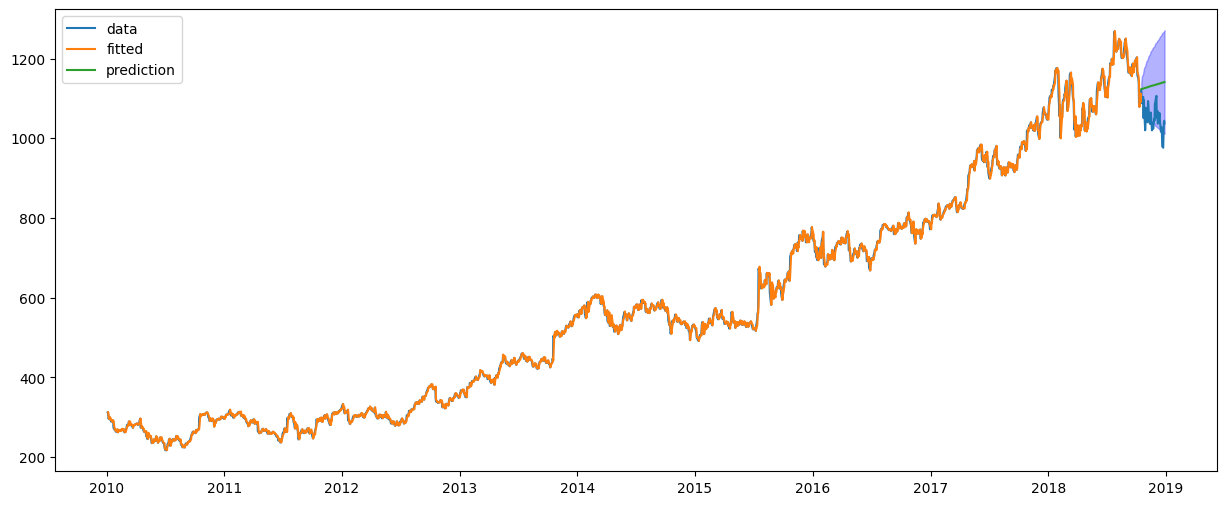

In [ ]:
plot_result(model, goog, train, test)

In [ ]:
def plot_test(model, test):
  pred, confint = model.predict(n_periods=len(test), return_conf_int=True)
  fig, ax = plt.subplots(figsize=(15,6))
  ax.plot(test.index, test, label='data')
  ax.plot(test.index, pred, label='prediction')
  ax.fill_between(test.index, confint[:,0], confint[:,1], color='b', alpha=0.3)
  ax.legend()
  plt.show();


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


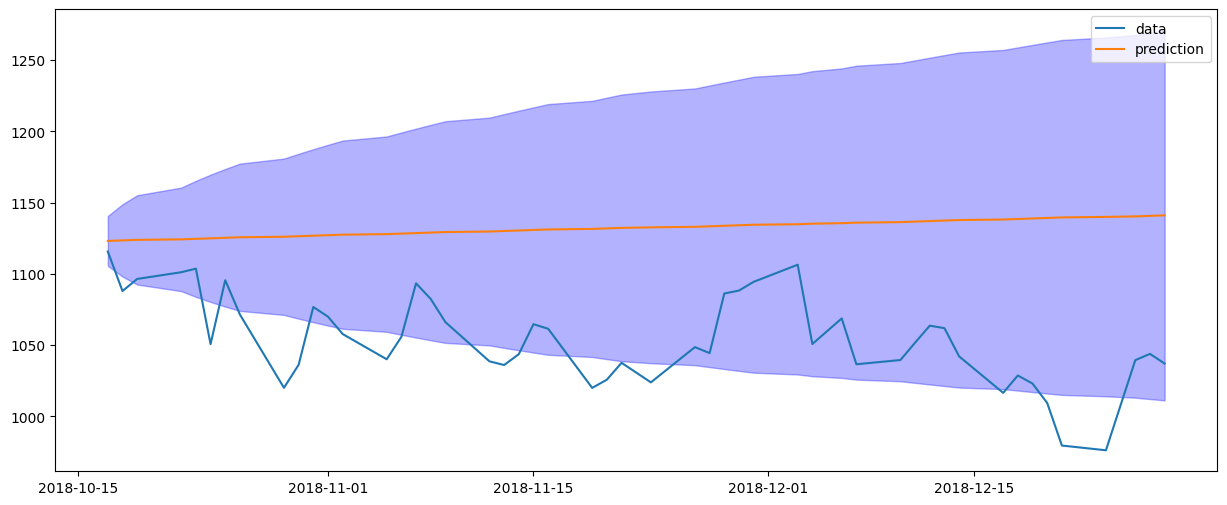

In [ ]:
plot_test(model, test)

#### Now, let's calculate the RMSE

In [ ]:
def rmse(actual, pred):
    # If inputs are DataFrames, convert to Series
    if isinstance(actual, pd.DataFrame):
        actual = actual.squeeze()
    if isinstance(pred, pd.DataFrame):
        pred = pred.squeeze()

    # Ensure inputs are Pandas Series or NumPy arrays
    if not isinstance(actual, (pd.Series, np.ndarray)):
        raise ValueError("actual must be a Pandas Series or NumPy array.")
    if not isinstance(pred, (pd.Series, np.ndarray)):
        raise ValueError("pred must be a Pandas Series or NumPy array.")

    # Convert to NumPy arrays if they are Pandas Series
    if isinstance(actual, pd.Series):
        actual = actual.to_numpy()
    if isinstance(pred, pd.Series):
        pred = pred.to_numpy()

    # Check for NaNs
    if np.isnan(actual).sum() > 0 or np.isnan(pred).sum() > 0:
        raise ValueError("Input arrays contain NaN values.")

    # Check for infinite values
    if np.isinf(actual).sum() > 0 or np.isinf(pred).sum() > 0:
        raise ValueError("Input arrays contain infinite values.")

    # Calculate RMSE
    return np.sqrt(np.mean((pred - actual)**2))

In [ ]:
rmse(test, pred)

85.00126085594634

In [ ]:
rmse(train[1:], model.predict_in_sample(start=1, end=-1))

8.931350654733821

Now let's see what RMSE it gives on (8,1,8 model)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
model = ARIMA(train, order=(1, 1, 0))
model_fit_110 = model.fit()
pred110 = model_fit.forecast(N_train)
rmse(test, pred110)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

75.20452463598127

In [ ]:
model = ARIMA(train, order=(0, 1, 1))
model_fit_011 = model.fit()
pred011 = model_fit.forecast(N_train)
rmse(test, pred011)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

75.20452463598127